In [1]:
#some methods copied from lesson2

In [49]:
batch_size=64
HOMEPATH = "/home/ubuntu/fastai/"
DATA_HOME_DIR = HOMEPATH + "data/dogscats/"
path = HOMEPATH + "data/dogscats/sample/"
model_path = path + 'models/'
test_path = DATA_HOME_DIR + 'test/'      #We use all the test data


In [3]:
from datetime import datetime
import os

In [4]:
from keras import backend as K
import os

def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("theano")

Using TensorFlow backend.
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [5]:
os.chdir(HOMEPATH)
print ("os.getcwd:", os.getcwd())
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import utils; reload(utils)
from utils import *

('os.getcwd:', '/home/ubuntu/fastai')


In [6]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [7]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [8]:
os.chdir(HOMEPATH)
print(os.getcwd())
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model
print (type(vgg))
print (type(model))

/home/ubuntu/fastai
<type 'instance'>
<class 'keras.models.Sequential'>


In [9]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)

Found 50 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [69]:
print (type(batches))
print (type(val_batches))

<class 'keras.preprocessing.image.NumpyArrayIterator'>
<class 'keras.preprocessing.image.NumpyArrayIterator'>


In [11]:
#utils.get_data
val_data = get_data(path+'valid')
print (type(val_data), val_data.shape)

Found 50 images belonging to 2 classes.
<type 'numpy.ndarray'> (50, 3, 224, 224)


In [12]:
trn_data = get_data(path+'train')
print ("trn_data:", type(trn_data), trn_data.shape)

Found 200 images belonging to 2 classes.
trn_data: <type 'numpy.ndarray'> (200, 3, 224, 224)


In [19]:
#useful function since keras returns classes as a single column, so we convert to one hot encoding
def onehot(x): 
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [22]:
val_classes = val_batches.classes
trn_classes = batches.classes
print ("val_classes:", type(val_classes), val_classes.shape)
print("val_classes[0:10]:", val_classes[0:10])
print ("trn_classes:", type(trn_classes), trn_classes.shape)
print("trn_classes[0:10]:", trn_classes[0:10])
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)
print ("val_labels:", val_labels[0])
print ("trn_labels:", trn_labels[0])
print ("trn_labels.shape:", trn_labels.shape)

val_classes: <type 'numpy.ndarray'> (50,)
val_classes[0:10]: [0 0 0 0 0 0 0 0 0 0]
trn_classes: <type 'numpy.ndarray'> (200,)
trn_classes[0:10]: [0 0 0 0 0 0 0 0 0 0]
val_labels: [ 1.  0.]
trn_labels: [ 1.  0.]
trn_labels.shape: (200, 2)


In [21]:
print ("start")
startTime= datetime.now()
trn_features = model.predict(trn_data, batch_size=batch_size)
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))


startTime= datetime.now()
val_features = model.predict(val_data, batch_size=batch_size)
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))

start
Time elpased (hh:mm:ss.ms) 0:00:08.018998
Time elpased (hh:mm:ss.ms) 0:00:01.159265


In [23]:
print ("trn_features:", trn_features.shape)
print ("val_features:", val_features.shape)

trn_features: (200, 1000)
val_features: (50, 1000)


In [24]:
#helper function to display images
#needs access to filenames.
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

In [26]:
filenames = val_batches.filenames
n_view = 4

In [25]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [27]:
print ("before pop, # of layers:", len(model.layers))
model.pop()
print ("after pop, # of layers:", len(model.layers))
for layer in model.layers: layer.trainable=False

before pop, # of layers: 38
after pop, # of layers: 37


In [28]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [29]:
model.add(Dense(2, activation='softmax'))
print ("after adding dense layer, # of layers:", len(model.layers))


after adding dense layer, # of layers: 38


In [30]:
gen=image.ImageDataGenerator()
print ("gen:", type(gen))
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
#https://keras.io/preprocessing/image/
#flow(x, y): Takes numpy data & label arrays, 
#and generates batches of augmented/normalized data. 
#Yields batches indefinitely, in an infinite loop.

val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

print ("batches:", type(batches))
print ("val_batches:", type(val_batches))

gen: <class 'keras.preprocessing.image.ImageDataGenerator'>
batches: <class 'keras.preprocessing.image.NumpyArrayIterator'>
val_batches: <class 'keras.preprocessing.image.NumpyArrayIterator'>


In [31]:
#helper function
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, 
                        samples_per_epoch=batches.n, 
                        nb_epoch=nb_epoch, 
                        validation_data=val_batches, 
                        nb_val_samples=val_batches.n)

In [32]:
opt = RMSprop(lr=0.1)
#https://keras.io/optimizers/#rmsprop
#This optimizer is usually a good choice for recurrent neural networks.
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
print ("start")
startTime= datetime.now()
fit_model(model, batches, val_batches, nb_epoch=2)
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))


start
Epoch 1/2
200/200 [==============================] - 7s - loss: 1.5477 - acc: 0.7650 - val_loss: 0.9671 - val_acc: 0.9400
Epoch 2/2
200/200 [==============================] - 6s - loss: 0.3224 - acc: 0.9800 - val_loss: 0.9671 - val_acc: 0.9400
Time elpased (hh:mm:ss.ms) 0:00:21.427714


In [34]:
print ("start")
startTime= datetime.now()
preds = model.predict_classes(val_data, batch_size=batch_size)
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))


start
50/50 [==============================] - 1s
Time elpased (hh:mm:ss.ms) 0:00:04.147759


In [35]:
print ("start")
startTime= datetime.now()
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))


start
50/50 [==============================] - 1s
Time elpased (hh:mm:ss.ms) 0:00:01.175081


In [36]:
cm = confusion_matrix(val_classes, preds)

[[22  2]
 [ 1 25]]


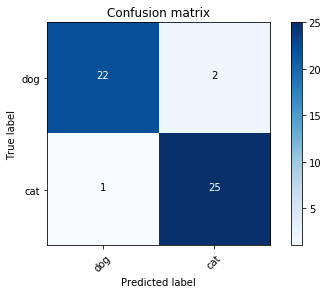

In [37]:
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

In [38]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [39]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
print ("first_dense_idx:", type(first_dense_idx), first_dense_idx)
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: 
    layer.trainable=True

first_dense_idx: <type 'int'> 33


In [40]:
vgg.model.summary
#vgg.model.summary produces <bound method Sequential.summary of <keras.models.Sequential object at 0x7f0982ce60d0>>
#because 

<bound method Sequential.summary of <keras.models.Sequential object at 0x7efca75224d0>>

In [41]:
#recall from above: from keras import backend as K
K.set_value(opt.lr, 0.01)
#https://keras.io/backend/
#keras.backend.set_value(x, value)
#https://www.tensorflow.org/api_docs/python/tf/keras/backend/set_value

print ("start fitting")   
startTime= datetime.now()
fit_model(model, batches, val_batches, 3)
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))


start fitting
Epoch 1/3
200/200 [==============================] - 6s - loss: 0.2877 - acc: 0.9700 - val_loss: 0.9671 - val_acc: 0.9400
Epoch 2/3
200/200 [==============================] - 6s - loss: 0.4030 - acc: 0.9750 - val_loss: 0.9671 - val_acc: 0.9400
Epoch 3/3
200/200 [==============================] - 6s - loss: 0.2418 - acc: 0.9850 - val_loss: 0.9671 - val_acc: 0.9400
Time elpased (hh:mm:ss.ms) 0:00:19.963978


In [42]:
#
for layer in layers[12:]: 
    print(type(layer))
    layer.trainable=True
K.set_value(opt.lr, 0.001)

<class 'keras.layers.convolutional.Convolution2D'>
<class 'keras.layers.convolutional.ZeroPadding2D'>
<class 'keras.layers.convolutional.Convolution2D'>
<class 'keras.layers.convolutional.ZeroPadding2D'>
<class 'keras.layers.convolutional.Convolution2D'>
<class 'keras.layers.pooling.MaxPooling2D'>
<class 'keras.layers.convolutional.ZeroPadding2D'>
<class 'keras.layers.convolutional.Convolution2D'>
<class 'keras.layers.convolutional.ZeroPadding2D'>
<class 'keras.layers.convolutional.Convolution2D'>
<class 'keras.layers.convolutional.ZeroPadding2D'>
<class 'keras.layers.convolutional.Convolution2D'>
<class 'keras.layers.pooling.MaxPooling2D'>
<class 'keras.layers.convolutional.ZeroPadding2D'>
<class 'keras.layers.convolutional.Convolution2D'>
<class 'keras.layers.convolutional.ZeroPadding2D'>
<class 'keras.layers.convolutional.Convolution2D'>
<class 'keras.layers.convolutional.ZeroPadding2D'>
<class 'keras.layers.convolutional.Convolution2D'>
<class 'keras.layers.pooling.MaxPooling2D'>
<

In [43]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [44]:
print ("start")
startTime= datetime.now()
fit_model(model, batches, val_batches, 4)
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))


start
Epoch 1/4
200/200 [==============================] - 7s - loss: 0.6448 - acc: 0.9600 - val_loss: 0.9671 - val_acc: 0.9400
Epoch 2/4
200/200 [==============================] - 6s - loss: 0.2418 - acc: 0.9850 - val_loss: 0.9671 - val_acc: 0.9400
Epoch 3/4
200/200 [==============================] - 6s - loss: 0.4030 - acc: 0.9750 - val_loss: 0.9671 - val_acc: 0.9400
Epoch 4/4
200/200 [==============================] - 6s - loss: 0.4030 - acc: 0.9750 - val_loss: 0.9671 - val_acc: 0.9400
Time elpased (hh:mm:ss.ms) 0:00:27.405537


In [45]:
print (type(model), len(model.layers))

<class 'keras.models.Sequential'> 38


In [50]:
print ("test_path:", test_path)

test_path: /home/ubuntu/fastai/data/dogscats/test/


In [54]:
print (type(vgg.model), len(vgg.model.layers))

<class 'keras.models.Sequential'> 38


In [55]:
model.evaluate_generator(get_batches(path+'valid', gen, False, batch_size*2), val_batches.n)

Found 50 images belonging to 2 classes.


[0.96708577871322632, 0.93999999761581421]

In [59]:
print("start")
startTime= datetime.now()
test_data = get_data(test_path)
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))


startTime= datetime.now()
print (type(test_data), test_data.shape)
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
print("end")


Found 12500 images belonging to 1 classes.
<type 'numpy.ndarray'> (12500, 3, 224, 224)


In [61]:
print("start")
startTime= datetime.now()
pred = model.predict(test_data, batch_size=batch_size)
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))


start
Time elpased (hh:mm:ss.ms) 0:04:54.308121


In [63]:
print(type(pred), pred.shape)
print(pred[0:5])

<type 'numpy.ndarray'> (12500, 2)
[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]]


In [67]:
count = 0
acc=0.4
for i in range(pred.shape[0]):
    if pred[i, 0]<(1.0-acc) and pred[i, 0]>acc:
        print(pred[i])
        count+=1
print (count)

[ 0.5434  0.4566]
1
